# Notebook 4: Poisson Equation

Introduces the various solver templates that are available in Underworld, starting with a steady-state diffusion problem. The template requires you to set some constitutive properties and define the unknowns. These are handled through subsitution into symbolic forms and the template equation can be inspected before you need to supply concrete expressions.

In this example, we solve a steady, non-linear, scalar diffusion equation and show how to recover the fluxes

In [1]:
#|  echo: false  # Hide in html version

# This is required to fix pyvista 
# (visualisation) crashes in interactive notebooks (including on binder)

import nest_asyncio
nest_asyncio.apply()

In [2]:
#| output: false # Suppress warnings in html version

import underworld3 as uw
import numpy as np
import sympy

In [3]:
mesh = uw.meshing.UnstructuredSimplexBox(
    minCoords=(0.0, 0.0), maxCoords=(1.0, 1.0), cellSize=1 / 12, qdegree=3
)

x, y = mesh.X

mesh.view()


Mesh # 0: .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.08333333333333333_regFalse.msh
Length scale: 1.0 (no scaling)


Widget(value='<iframe src="http://localhost:61458/index.html?ui=P_0x33a554dd0_0&reconnect=auto" class="pyvista…

Number of cells: 346
No variables are defined on the mesh
| Boundary Name | ID |
| -------------------------------- |
| Bottom | 11 |
| Top | 12 |
| Right | 13 |
| Left | 14 |
| Null_Boundary | 666 |
| All_Boundaries | 1001 |
| All_Boundaries | 1001 |
| UW_Boundaries | -- |
| -------------------------------- |

Use view(1) to view detailed mesh information.



In [4]:
# mesh variables

t_soln = uw.discretisation.MeshVariable("T", mesh, 1, degree=3)
dTdY = uw.discretisation.MeshVariable(
    r"dTdY", mesh, 1, degree=2,
    varsymbol=r"\partial T/\partial y")


### The Poisson (Diffusion) Solver

There are a number of pre-defined *solver systems* defined in `underworld3` 
which are templates for orchestrating the underlying PETSc objects. 
A solver requires us to define the unknown in the form of `meshVariables`, 
provide boundary conditions, a constitutive model, 
and provide `uw.functions` to define constitutive
properties, and driving terms.

We will use the `Poisson` solver for the diffusion equation, and we will 
use a `Projection` solver to compute the vertical gradient term. 

The `Projection` solvers compute the `meshVariable` representation of the right hand side of the equation (potentially 
requiring some smoothing to regularise the problem). This is required when computing numerical values of gradients, for
example, where the values are often not formally defined on the mesh points of the `meshVariable`. This can also be used to
transfer information from discontinous variables to continuous representations when you need to visualise a field.

The solver classes themselves (the templates for specific solvers) are separately documented, so we can figure out what 
is needed before we define anything:


In [5]:
uw.systems.Poisson.view()


# Poisson Equation Solver

This class provides functionality for a discrete representation
of the Poisson equation

$$
\nabla \cdot
        \color{Blue}{\underbrace{\Bigl[ \boldsymbol\kappa \nabla u \Bigr]}_{\mathbf{F}}} =
        \color{Maroon}{\underbrace{\Bigl[ f \Bigl] }_{\mathbf{h}}}
$$

The term $\mathbf{F}$ relates the flux to gradients in the unknown $u$

## Properties

  - The unknown is $u$

  - The diffusivity tensor, $\kappa$ is provided by setting the `constitutive_model` property to
one of the scalar `uw.constitutive_models` classes and populating the parameters.
It is usually a constant or a function of position / time and may also be non-linear
or anisotropic.

  - $f$ is a volumetric source term


In [6]:
uw.systems.Projection.view()


# Projection Solver

Solves $u = \tilde{f}$ where $\tilde{f}$ is a function that can be evaluated within an element and
$u$ is a `meshVariable` with associated shape functions. Typically, the projection is used to obtain a
continuous representation of a function that is not well defined at the mesh nodes. For example, functions of
the spatial derivatives of one or more `meshVariable` (e.g. components of fluxes) can be mapped to continuous
variables with a projection. More broadly it is a projection from one basis to another and its limitations should be
evaluated within that context.

The projection implemented by creating a solver for this problem

$$
-\nabla \cdot
        \color{Blue}{\underbrace{\Bigl[ \boldsymbol\alpha \nabla u \Bigr]}_{\mathbf{F}}} -
        \color{Maroon}{\underbrace{\Bigl[ u - \tilde{f} \Bigl] }_{\mathbf{h}}} = 0
$$

Where the term $\mathbf{F}$ provides a smoothing regularization. $\alpha$ can be zero.


### Constitutive Models

Most of the solvers require a constitutive model to be provided and its
parameters populated. This is to allow flexibility in defining / redefining 
solvers during a model calculation.

We need a diffusion model. We can look at the documentation first. 

In [7]:
uw.constitutive_models.DiffusionModel.view()


```python
class DiffusionModel(Constitutive_Model)
...
```
```python
diffusion_model = DiffusionModel(dim)
diffusion_model.material_properties = diffusion_model.Parameters(diffusivity=diffusivity_fn)
scalar_solver.constititutive_model = diffusion_model
```
$$q_{i} = \kappa_{ij} \cdot \frac{\partial \phi}{\partial x_j}$$

where $\kappa$ is a diffusivity, a scalar constant, `sympy` function, `underworld` mesh variable or
any valid combination of those types. Access the constitutive model using:

```python
flux = diffusion_model.flux(gradient_matrix)
```
---


### Problem setup

We will make the problem "interesting" by defining a non-linear diffusivity

$$
    \kappa = \kappa_0 + \left| \nabla T \right |^2
$$

and apply a zero source term, non-zero boundary conditions on the top and bottom surfaces.
The names of the boundaries of the mesh can be found by looking at `mesh.view()` above.

In [8]:
# The steady-state diffusion

poisson = uw.systems.Poisson(mesh, u_Field=t_soln)
poisson.constitutive_model = uw.constitutive_models.DiffusionModel

# Non-linear diffusivity

delT = mesh.vector.gradient(t_soln.sym)
k =  1 - (delT.dot(delT)) 

abs_r2 = x**2 + y**2
poisson.f = -abs_r2

# Essential boundary conditions

poisson.add_essential_bc([0], "Bottom")
poisson.add_essential_bc([1], "Top"  )

# Create Projection solver for gradient terms 

gradient = uw.systems.Projection(mesh, dTdY)
gradient.uw_function = t_soln.sym.diff(y)
gradient.smoothing = 1.0e-6

# Linear model - starting guess

poisson.constitutive_model.Parameters.diffusivity = 1
poisson.solve(zero_init_guess=True)

# Solve time
poisson.constitutive_model.Parameters.diffusivity = k
poisson.solve(zero_init_guess=False)

# Solve the gradient
gradient.solve()


#### Non-linear problems, Jacobian

This is a non-linear problem and has a non-zero Jacobian ($\partial F / \partial \nabla T )$. 
It's a little bit hidden, but is available if you feel like checking:

In [9]:
display(poisson._G3)

Matrix([
[-3*{ \hspace{ 0.0004pt } {T} }_{,0}(N.x, N.y)**2 - { \hspace{ 0.0004pt } {T} }_{,1}(N.x, N.y)**2 + 1,             -2*{ \hspace{ 0.0004pt } {T} }_{,0}(N.x, N.y)*{ \hspace{ 0.0004pt } {T} }_{,1}(N.x, N.y)],
[            -2*{ \hspace{ 0.0004pt } {T} }_{,0}(N.x, N.y)*{ \hspace{ 0.0004pt } {T} }_{,1}(N.x, N.y), -{ \hspace{ 0.0004pt } {T} }_{,0}(N.x, N.y)**2 - 3*{ \hspace{ 0.0004pt } {T} }_{,1}(N.x, N.y)**2 + 1]])

In [10]:
dTdY[0]

{ \hspace{ 0.0004pt } {\partial T/\partial y} }(N.x, N.y)

In [11]:
from mpi4py import MPI

if MPI.COMM_WORLD.size == 1:
    
    import pyvista as pv
    import underworld3.visualisation as vis

    pvmesh = vis.mesh_to_pv_mesh(mesh)
    pvmesh.point_data["T"] = vis.scalar_fn_to_pv_points(pvmesh, t_soln[0])
    pvmesh.point_data["dTdY"] = vis.scalar_fn_to_pv_points(pvmesh, dTdY[0])

    pl = pv.Plotter(window_size=(1000, 500), shape=(1, 2))

    pl.subplot(0, 0)

    pl.add_mesh(
        pvmesh,
        cmap="coolwarm",
        edge_color="Black",
        show_edges=True,
        scalars="T",
        use_transparency=False,
        opacity=1,
        show_scalar_bar=True,
    )

    pl.subplot(0, 1)

    pl.add_mesh(
        pvmesh,
        cmap="coolwarm",
        edge_color="Black",
        show_edges=True,
        scalars="dTdY",
        use_transparency=False,
        opacity=1,
        scalar_bar_args=dict(vertical=False)

    )

    pl.export_html("html5/temperature_plot.html")

In [12]:
#| fig-cap: "Interactive Image: Square mesh of triangular elements on which we evaluated a non-linear diffusion problem and the vertical gradient of the solution"

from IPython.display import IFrame
IFrame(src="html5/temperature_plot.html", width=600, height=300)

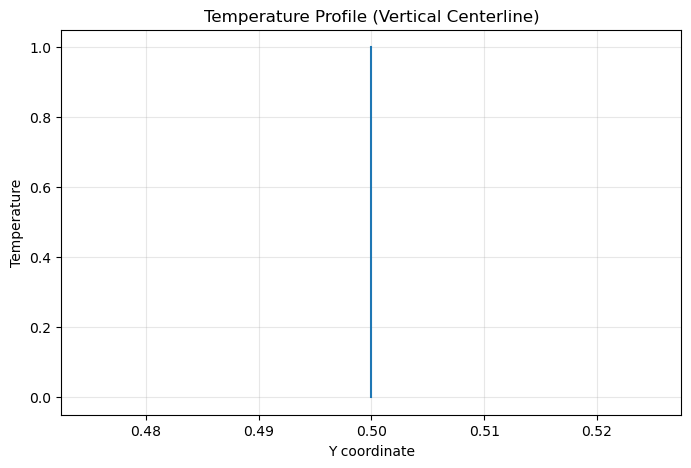

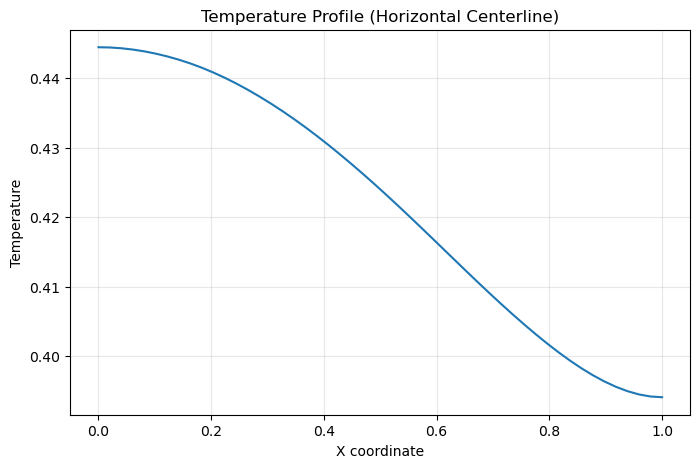

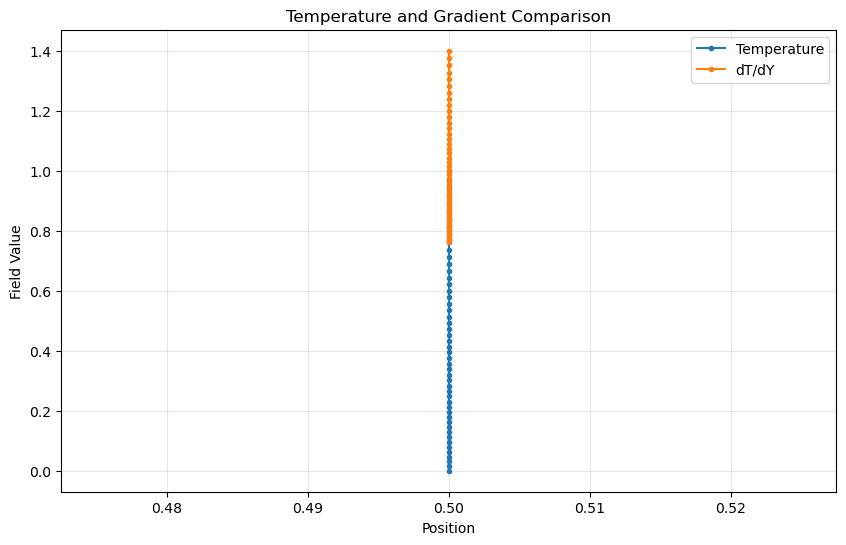

In [13]:
# Parallel-safe diagnostic plots

# Create sample lines for analysis
sample_points_vertical = uw.visualisation.parallel.create_vertical_line(x=0.5, num_points=50)
sample_points_horizontal = uw.visualisation.parallel.create_horizontal_line(y=0.5, num_points=50)

# Temperature profile along vertical centerline
uw.visualisation.parallel.parallel_line_plot(
    t_soln.sym, sample_points_vertical,
    title="Temperature Profile (Vertical Centerline)",
    xlabel="Y coordinate", ylabel="Temperature"
)

# Temperature profile along horizontal centerline  
uw.visualisation.parallel.parallel_line_plot(
    t_soln.sym, sample_points_horizontal,
    title="Temperature Profile (Horizontal Centerline)", 
    xlabel="X coordinate", ylabel="Temperature"
)

# Compare temperature and its gradient
uw.visualisation.parallel.parallel_profile_comparison(
    [t_soln.sym, dTdY.sym], 
    sample_points_vertical,
    labels=["Temperature", "dT/dY"],
    title="Temperature and Gradient Comparison"
)

## Parallel-Safe Diagnostic visualisation

The visualisation above using PyVista only works when running on a single process. For parallel execution or when you want simple diagnostic plots, we can use parallel-safe matplotlib patterns.

These functions use `global_evaluate` with asymmetric calling: rank 0 requests data at sample points while other ranks participate with empty arrays. This allows all processes to contribute to data gathering while only one process creates the visualisation.

# Exercise 4.1

Since diffusivity, $\kappa$, depends on the gradient of temperature, it also needs to be calculated using a projection to the mesh nodes. You can use the computation for $\partial T / \partial y$ as a template to calculate and plot $\kappa$, or you can compute the vertical flux term and plot that.